In [1]:
import os
os.chdir('../../')

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Mon Mar 31 13:41:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   35C    P8             47W /  350W |     169MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### from "sample pair.ipynb"

In [3]:
import torch
import torch.nn.functional as F

total_samples = 256
save_file = f'/data/optimization/euler_NFE=1000_N={total_samples}_imagenet64.pt'
pairs = torch.load(save_file)
noise = pairs[:, 0]
target = pairs[:, 1]
print(noise.shape, target.shape)

torch.Size([256, 3, 64, 64]) torch.Size([256, 3, 64, 64])


In [4]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--skip_type", "logSNR",
    "--ni",

    "--sample_type", "rbfsolverglq10laggrid",
    "--timesteps", "5",
    "--log_scale_min", "-2.0",
    "--log_scale_max", "3.0",
    "--log_scale_num", "33",
    "--scale_dir", "/data/data/rbfsolverglq10laggrid",
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device


INFO - main.py - 2025-03-31 13:41:57,997 - Using device: cuda


[prepare_model] Model is ready.


In [5]:
!mkdir /data/data/rbfsolverglq10laggrid
!ls /data/data/rbfsolverglq10laggrid

mkdir: cannot create directory ‘/data/data/rbfsolverglq10laggrid’: File exists
'NFE=10,p=3,dataset=IMAGENET64.npy'  'NFE=25,p=3,dataset=IMAGENET64.npy'
'NFE=15,p=3,dataset=IMAGENET64.npy'  'NFE=5,p=3,dataset=IMAGENET64.npy'


In [6]:
n = 256
noise_batch = noise[:n].to(device)
target_batch = target[:n].to(device)
print(noise_batch.shape)
(pred, optimal_log_scales, loss_grid_list), _ = diffusion.sample_image(noise_batch, diffusion.model, target=target_batch)
loss = F.mse_loss(pred, target_batch)
print(loss)

torch.Size([256, 3, 64, 64])
/data/data/rbfsolverglq10laggrid/NFE=5,p=3,dataset=IMAGENET64.npy  saved!
tensor(0.0414, device='cuda:0')


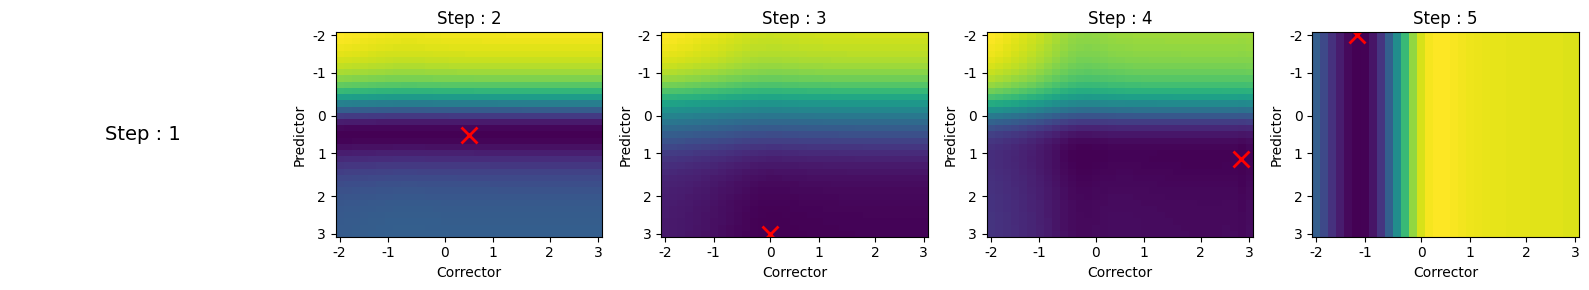

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_grid_list(loss_grid_list, args):
    """
    subplot (num_rows x num_cols)에서 (0,0)은 비워두고 'Step : 1' 표시,
    나머지 (0,1)부터 순차적으로 loss_grid를 그립니다.
    x축, y축 값은 log_scale_min ~ log_scale_max 사이의 '정수'에 해당하는 지점만 표기합니다.
    """
    num_plots = len(loss_grid_list)
    num_cols = 5
    num_rows = math.ceil(num_plots / num_cols)
    
    # 축 레이블용 값 (linspace)
    axis = np.linspace(args.log_scale_min, args.log_scale_max, args.log_scale_num)
    
    # figure, axes 생성
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3 * num_rows))
    
    # axes 2차원 보장
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)
    
    # ------------------------
    # (0,0)을 비우고, 중앙에 'Step : 1' 표시
    # ------------------------
    ax_empty = axes[0, 0]
    ax_empty.set_axis_off()
    ax_empty.text(0.5, 0.5, "Step : 1", fontsize=14,
                  ha='center', va='center', transform=ax_empty.transAxes)
    
    # ------------------------
    # x축, y축에서 찍을 '정수' 목록과 해당 인덱스 찾기
    # ------------------------
    # 예: log_scale_min=-1, log_scale_max=2 라면, -1~2 정수 => -1,0,1,2
    start_int = int(math.floor(args.log_scale_min))
    end_int   = int(math.ceil(args.log_scale_max))
    
    x_indices = []
    x_labels  = []
    y_indices = []
    y_labels  = []
    
    # x축 / y축이 같은 axis라서 로직은 동일
    for int_val in range(start_int, end_int + 1):
        # axis에서 이 int_val에 가장 가까운 인덱스를 찾음
        idx = np.argmin(np.abs(axis - int_val))
        
        # x, y 둘 다 같은 방식으로 추가
        x_indices.append(idx)
        x_labels.append(str(int_val))
        
        y_indices.append(idx)
        y_labels.append(str(int_val))
    
    # 이제 (0,1)부터 loss_grid 시각화
    max_subplots = num_rows * num_cols
    
    for i, loss_grid in enumerate(loss_grid_list):
        subplot_index = i + 1  # (0,0)은 비웠으므로
        
        if subplot_index >= max_subplots:
            print("Warning: subplot 갯수 초과. 일부 데이터는 표시되지 않습니다.")
            break
        
        row = subplot_index // num_cols
        col = subplot_index % num_cols
        
        ax = axes[row, col]
        ax.set_title(f"Step : {i + 2}")
        
        # 히트맵
        im = ax.imshow(loss_grid, aspect='auto', interpolation='nearest')
        
        # X축, Y축에 '정수' 인덱스만 표시
        ax.set_xticks(x_indices)
        ax.set_xticklabels(x_labels)
        ax.set_yticks(y_indices)
        ax.set_yticklabels(y_labels)
        
        ax.set_xlabel("Corrector")
        ax.set_ylabel("Predictor")
        
        # 최소값 위치 표시
        min_idx = np.argmin(loss_grid)
        min_row, min_col = np.unravel_index(min_idx, loss_grid.shape)
        ax.plot(min_col, min_row, 'x', markersize=12, markeredgewidth=2, color='red')
        
        # 필요 시 컬러바
        # fig.colorbar(im, ax=ax, format='%.3f')

    plt.tight_layout()
    plt.show()

plot_loss_grid_list(loss_grid_list, args)


In [9]:
import numpy as np

def row_col_correlation(matrix: np.ndarray) -> float:
    """
    (n x n) 2차원 넘파이 배열을 입력받아,
    행별 합 벡터와 열별 합 벡터 간의 피어슨 상관계수를 반환합니다.

    :param matrix: (n x n) 형태의 수치형 numpy 배열
    :return: 행 합과 열 합 간의 상관계수 (float)
    """
    # 행별 합: shape (n,)
    row_sums = matrix.sum(axis=1)
    # 열별 합: shape (n,)
    col_sums = matrix.sum(axis=0)
    
    # 만약 row_sums나 col_sums가 모두 같은 값이라 분산=0이면
    # 상관계수가 정의되지 않으므로, 에러 처리 또는 None 반환
    if np.all(row_sums == row_sums[0]) or np.all(col_sums == col_sums[0]):
        # 예: 에러 발생시키기
        raise ValueError("행 합 또는 열 합이 모두 동일하여 상관계수를 구할 수 없습니다.")
    
    # 피어슨 상관계수 계산: np.corrcoef(2개 벡터)는 2x2 공분산 행렬을 반환
    corr_matrix = np.corrcoef(row_sums, col_sums)
    corr_value = corr_matrix[0, 1]  # off-diagonal 원소가 상관계수

    return corr_value

for i, loss_grid in enumerate(loss_grid_list):
    if i >= len(loss_grid_list)-1:
        break
    
    print('Step :', i+2, row_col_correlation(loss_grid))

Step : 2 0.3291454000812935
Step : 3 0.799416559774486
Step : 4 0.8118900799711105
